In [1]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [2]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")
nyt_df = pd.read_csv("data/nytimes_blm.csv")

wiki_df = pd.read_csv("data/wiki_blm.csv")


dfs = [ccc_df, ele_df, cl_df, wiki_df, nyt_df]

In [3]:
df = pd.concat(dfs).reset_index(drop=True)
display(df)

,id,date,city_st,location,size,size_str,urls,collection,Unnamed: 0
0,NaN,2020-06-01,"Albany, NY",", Albany, NY",NaN,NaN,['https://twitter.com/MelanieJoi03/status/1267...,CCC,NaN
1,NaN,2020-06-01,"Albuqeurque, NM","Bernadillo, Albuqeurque, NM",300,at least a few hundred,['https://twitter.com/cassy20481992/status/126...,CCC,NaN
2,NaN,2020-06-01,"Alton, NH",", Alton, NH",7,7,['https://twitter.com/seedevonwrite/status/126...,CCC,NaN
3,NaN,2020-06-01,"Anaheim, CA","City Hall, Anaheim, CA",500,more than 500,['https://www.ocregister.com/anaheim-park-host...,CCC,NaN
4,NaN,2020-06-01,"Asbury Park, NJ","start at Post Office , Asbury Park, NJ",5000,about 5000,['https://nyc.epeak.in/2020/06/02/police-offic...,CCC,NaN
...,...,...,...,...,...,...,...,...,...
9245,NaN,06/08/2020,"Tupper Lake, NY",NaN,NaN,NaN,['https://www.adirondackdailyenterprise.com/ne...,New York Times,NaN
9246,NaN,06/08/2020,"Delmar, NY",NaN,NaN,NaN,['https://www.timesunion.com/news/article/Rall...,New York Times,NaN
9247,NaN,06/08/2020,"Clifton Park, NY",NaN,NaN,NaN,['https://cbs6albany.com/news/local/high-schoo...,New York Times,NaN
9248,NaN,06/08/2020,"Claremont, NH",NaN,NaN,NaN,['https://www.youtube.com/watch?v=gR8IeATEUzY'],New York Times,NaN


In [4]:
df['collection'].value_counts()

Count Love        3012
New York Times    2633
CCC               1941
Wikipedia          884
Elephrame          780
Name: collection, dtype: int64

In [5]:
date_start = pd.to_datetime('2020-05-25')
df = df[pd.to_datetime(df['date']) > date_start].copy()
df = df[pd.to_datetime(df['date']) <= pd.Timestamp.today()].copy()


In [6]:
df['date'] = pd.to_datetime(df['date']).dt.date
df['date'].value_counts()

2020-05-31    1135
2020-06-01     988
2020-06-06     932
2020-06-02     919
2020-05-30     815
2020-06-03     691
2020-06-05     639
2020-06-07     588
2020-06-04     497
2020-05-29     263
2020-06-13     193
2020-06-08     174
2020-06-12     166
2020-06-14     149
2020-06-09     105
2020-06-10      93
2020-05-28      90
2020-06-11      66
2020-06-15      25
2020-06-16      23
2020-05-27      22
2020-05-26      14
2020-06-17      10
Name: date, dtype: int64

In [7]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

8597

In [8]:
# eliminate non US events

countries = [
    "Finland",
    "England", "France", "Germany",
    "Wales",
    "Canada",
    "Scotland", 'Sweden', 'Ottowa'
    "Germany", "Netherlands"
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium", "Uganda", 'Croatia'
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = "," + c
        if c2.lower() in city_st.lower().replace(' ',''):
            print(city_st)
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

British Columbia, Canada
Québec, Canada
Welwyn Garden City, England
Aberdeen, Scotland
Brighton, England
Ulm, Germany
Guildford, England
Nova Scotia, Canada
Kampala, Uganda
Crawley, England
Cheltenham, England
Cologne, Germany
Bonn, Germany
Coventry, England
Coventry, England
Horsham, England
Northwest Territories, Canada
Brussels, Belgium
Budapest, Hungary
Cairns, Australia
London, England
London, England
Bristol, England
Glasgow, Scotland
Edinburgh, Scotland
Flensburg, Germany
Cologne, Germany
Bonn, Germany
Hamburg, Germany
Munich, Germany
Berlin, Germany
Alberta, Canada
Saskatchewan, Canada
London, England
Alberta, Canada
Redditch, England
London, England
Ontario, Canada
Canberra, Australia
Alberta, Canada
Lincoln, England
Hull, England
Helsinki, Finland
Alberta, Canada
Alberta, Canada
Stockholm, Sweden
London, England
Alberta, Canada
Alberta, Canada
Paris, France
Halifax, Canada
Berlin, Germany
British Columbia, Canada
Cardiff, Wales
Montreal, Canada


8542

In [9]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [10]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [11]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [12]:
df['size'] = df['size'].replace('20,000',20000).replace('$1,000.00',np.nan).replace('hundreds', 200).replace('a  large crowd', np.nan).astype(float)

In [13]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

/Users/nealcaren/opt/anaconda3/envs/tmwp/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First Pass at Aggregation

In [14]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [15]:
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [16]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame",
         "Wikipedia",
         "New York Times"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [17]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Wikipedia" : "max",
    "Count Love" : "max",
    "Elephrame" : "max",
    "New York Times": "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [18]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [19]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",
    "New York Times",
    "Wikipedia"

]

In [20]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [21]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [22]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




In [23]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max',
                                              "New York Times" : 'max',
                                             'Wikipedia' : 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love', 'New York Times', 'Wikipedia']].sum().to_markdown())

| date       |   cities |   Elephrame |   CCC |   Count Love |   New York Times |   Wikipedia |
|:-----------|---------:|------------:|------:|-------------:|-----------------:|------------:|
| 2020-05-26 |       10 |           1 |     0 |            7 |                6 |           0 |
| 2020-05-27 |       17 |           0 |     0 |           11 |               11 |           0 |
| 2020-05-28 |       58 |           0 |     0 |           41 |               41 |           8 |
| 2020-05-29 |      164 |           0 |     0 |          128 |               94 |          39 |
| 2020-05-30 |      450 |           0 |     0 |          340 |              337 |         128 |
| 2020-05-31 |      647 |          75 |     0 |          428 |              460 |         156 |
| 2020-06-01 |      556 |          48 |   168 |          310 |              330 |          93 |
| 2020-06-02 |      539 |          38 |   193 |          276 |              297 |          58 |
| 2020-06-03 |      422 |          70 | 

In [24]:
display("Cities:", len(df_cd['city_st'].value_counts()))

'Cities:'

2696

In [25]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date       |   events |
|:-----------|---------:|
| 2020-05-26 |       10 |
| 2020-05-27 |       17 |
| 2020-05-28 |       58 |
| 2020-05-29 |      166 |
| 2020-05-30 |      460 |
| 2020-05-31 |      655 |
| 2020-06-01 |      585 |
| 2020-06-02 |      578 |
| 2020-06-03 |      452 |
| 2020-06-04 |      368 |
| 2020-06-05 |      423 |
| 2020-06-06 |      636 |
| 2020-06-07 |      408 |
| 2020-06-08 |      132 |
| 2020-06-09 |       82 |
| 2020-06-10 |       72 |
| 2020-06-11 |       56 |
| 2020-06-12 |      140 |
| 2020-06-13 |      155 |
| 2020-06-14 |      122 |
| 2020-06-15 |       16 |
| 2020-06-16 |       17 |
| 2020-06-17 |        4 |


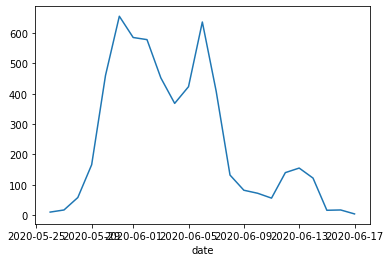

In [26]:
df_cd.groupby('date')['events'].sum().plot();

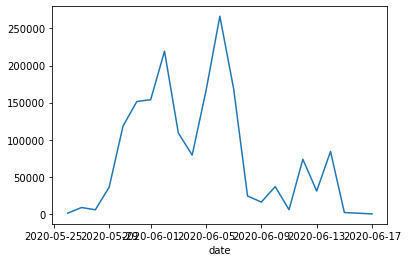

In [27]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [28]:
df_cd['size_imp'].count()

5150

In [29]:
display('Events:',df_cd['events'].sum())

'Events:'

5612

In [30]:
display("Size:",df_cd['size_imp'].sum())

'Size:'

1759342.0

In [31]:


df_cd['size'].describe()

count     2795.000000
mean       620.192129
std       2478.172236
min          1.000000
25%        100.000000
50%        200.000000
75%        400.000000
max      60200.000000
Name: size, dtype: float64

In [32]:
display(df_cd.groupby(["CCC", "Count Love", 'Elephrame','New York Times','Wikipedia'])['events'].count().reset_index())

,CCC,Count Love,Elephrame,New York Times,Wikipedia,events
0,0,0,0,0,1,158
1,0,0,0,1,0,1079
2,0,0,0,1,1,133
3,0,0,1,0,0,231
4,0,0,1,0,1,2
5,0,0,1,1,0,40
6,0,0,1,1,1,14
7,0,1,0,0,0,963
8,0,1,0,0,1,48
9,0,1,0,1,0,645


In [33]:
df_cd['city_st'].value_counts().to_frame().reset_index().sort_values(by='index').to_csv('cities.csv')